# Jupyter Note - Neural Style Transfer using VGG Network

# Import Packages

In [1]:
import sys
import os
import shutil

from typing import Tuple

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision

import tqdm

# Print Library Version
print(f"Python version={sys.version}")
print(f"torch version={torch.__version__}")
print(f"torchvision version={torchvision.__version__}")
print(f"matplotlib version={matplotlib.__version__}")
print(f"tdqm version={tqdm.__version__}")

from tqdm import tqdm

Python version=3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:50:49) [Clang 16.0.6 ]
torch version=2.5.1
torchvision version=0.20.1
matplotlib version=3.10.0
tdqm version=4.67.1


# Define Necessary Modules

## Model Architecture

In [3]:
"""Model Definition"""
class NSTNetwork(nn.Module):
    def __init__(
        self,
        feature_extractor : nn.Module,
        style_layer_names : list[str],
        content_layer_names : list[str],
        use_avgpool : bool = False
    ):
        super().__init__()

        # Get Indices
        self.style_loss_indices = [i for i, _ in enumerate(style_layer_names)]
        self.content_loss_indices = [i for i, name in enumerate(style_layer_names) if name in content_layer_names]

        # Define Normalisation Function
        self.normalise = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

        slices : list[nn.Sequencial] = []
        slice = nn.Sequential()

        i = 0;
        for layer in feature_extractor.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
                layer = nn.AvgPool2d(layer.kernel_size, layer.stride, layer.padding) if use_avgpool else layer
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            slice.add_module(name, layer)
            if name in style_layer_names:
                slices.append(slice)
                slice = nn.Sequential()

        self.extractor = nn.Sequential()
        for i, slice in enumerate(slices,1):
            self.extractor.add_module(f"slice_{i}", slice)

    def forward(self, x) -> list[torch.Tensor]:
        x = self.normalise(x)
        feature_maps : list[torch.Tensor] = []
        for slice in self.extractor.children():
            x = slice(x)
            feature_maps.append(x)
        return feature_maps

## Gram Matrix for Loss function

In [4]:
# Define gram matrix
def gram_matrix(ip : torch.Tensor) -> torch.Tensor:
    num_batch, num_channels, height, width = ip.size()
    feats = ip.view(num_batch * num_channels, width * height)
    gram_mat = torch.mm(feats, feats.t())
    return gram_mat.div(num_batch * num_channels * width * height)

## Auxiliary Functions

### Model Preparaion

In [5]:
def prepare_model(
    dvc,
    feature_extractor : nn.Module,
    style_layer_names: list[str],
    content_layer_names: list[str],
    use_avgpool : bool = False
) -> nn.Module:
    # Define Our Model
    net = NSTNetwork(
        feature_extractor=feature_extractor,
        style_layer_names=style_layer_names,
        content_layer_names=content_layer_names,
        use_avgpool=use_avgpool
    )

    # Disable Gradient and Turn Model to Evaluation Model
    net.requires_grad_(False)
    net.eval()
    net.to(dvc)

    return net

### Import image and convert to tensor

In [6]:
BIG_DIM=512
SMALL_DIM=128
image_dimension = BIG_DIM if torch.cuda.is_available() else SMALL_DIM

def image_to_tensor(image_filepath : str, image_dimension : int = SMALL_DIM) -> torch.Tensor:
    img = Image.open(image_filepath).convert('RGB')

    print(f"Original image size: {img.size}")

    # display image to check
    _, axs = plt.subplots(1,2, figsize=(10, 6))
    axs[0].set_title(f"{image_filepath}")
    axs[0].imshow(img)

    # Central-crop the image if it is not square
    if img.height != img.width:
        width, height = img.size
        min_dim = min(width, height)
        left = (width - min_dim) / 2
        top = (height - min_dim) / 2
        right = (width + min_dim) / 2
        bottom = (height + min_dim) / 2
        box = (left, top, right, bottom)
        img = img.crop(box)

    # Scale-up image if it is too small
    if img.height < image_dimension or img.width < image_dimension:
      scaling_factor = image_dimension / max(img.size)

      new_width = int(img.width * scaling_factor)
      new_height = int(img.height * scaling_factor)

      img = img.resize((new_width, new_height), Image.LANCZOS)

    print(f"New image size: {img.size}")

    torch_transformation = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_dimension),
        torchvision.transforms.ToTensor()
    ])

    img = torch_transformation(img).unsqueeze(0)

    # Display Processed Image, Sub plt
    axs[1].set_title(f"{image_filepath} Processed")
    axs[1].imshow(img.squeeze(0).cpu().detach().numpy().transpose(1,2,0))

    return img.to(torch.float)

## Style Transfering Process

In [ ]:
def style_transfer(
    # neural network
    net : nn.Module,
    # Inputs
    ip_image : torch.Tensor,
    content_image : torch.Tensor,
    style_image : torch.Tensor,

    # Optimiser
    lr : float,

    # loss function
    wt_style : float,
    wt_content : float,

    # Transfering Process
    num_epochs : int,
    loss_checkpoint_step : int,
    image_checkpoint_step : int,

    output_path : str
) -> Tuple[list[float], list[float]]:

    # Clean Output Directory
    if os.path.exists(output_path):
        shutil.rmtree(output_path) # Deletes the directory and all its contents
    os.makedirs(output_path) # Re-creates the empty directory

    ip_image.requires_grad_(True)

    opt = optim.LBFGS([ip_image], lr=lr)

    epoch_style_losses = []
    epoch_content_losses = []

    for curr_epoch in range(1, num_epochs+1):

        ip_image.data.clamp_(0, 1)

        opt.zero_grad()

        epoch_style_loss = 0
        epoch_content_loss = 0

        x = ip_image
        yc = content_image.detach()
        ys = style_image.detach()

        feature_maps_x = net(x)
        with torch.no_grad:
            feature_maps_yc = net(yc)
            feature_maps_ys = net(ys)

        for i,(f_x,f_yc,f_ys) in enumerate(zip(feature_maps_x,feature_maps_yc,feature_maps_ys)):
            if i in net.style_loss_indices:
                epoch_style_loss += F.mse_loss(gram_matrix(f_x), gram_matrix(f_ys.detach()).detach())
            if i in net.content_loss_indices:
                epoch_content_loss += F.mse_loss(f_x, f_yc.detach())

        epoch_style_loss *= wt_style
        epoch_content_loss *= wt_content

        total_loss = epoch_style_loss + epoch_content_loss
        total_loss.backward()

        def closure() -> torch.Tensor:
            return total_loss

        if curr_epoch % loss_checkpoint_step == 0:
            epoch_style_losses += [epoch_style_loss.cpu().detach().numpy()]
            epoch_content_losses += [epoch_content_loss.cpu().detach().numpy()]
            print(f"epoch number {curr_epoch}")
            print(f"style loss = {epoch_style_loss:.4f}, content loss = {epoch_content_loss:.4f}")

        if curr_epoch % image_checkpoint_step == 0:
            display_image = ip_image.data.clamp_(0, 1).squeeze(0).cpu().detach()
            plt.figure()
            plt.title(f"epoch number {curr_epoch}")
            plt.imshow(display_image.numpy().transpose(1,2,0))
            plt.show()
            torchvision.utils.save_image(
                display_image,
                f"{output_path}/image_{curr_epoch}.jpg"
            )

        opt.step(closure=closure)

    return (epoch_style_losses, epoch_content_losses)

# Google Drive Setup

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
# Change the current working directory
YOUR_WORKING_DIR_GDRIVE="MyDrive/Colab/neural-style-transfer/notebook"

import os;
os.chdir(f"/content/gdrive/{YOUR_WORKING_DIR_GDRIVE}")
print(os.getcwd())

/content/gdrive/MyDrive/Colab/neural-style-transfer/notebook


# Main Functions

## Select Device

In [8]:
dvc = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {dvc}")

Using device: cpu


## Create Directories if not exist

In [9]:
# Create Directory
INPUT_PATH="./inputs"
OUTPUT_PATH="./outputs"
os.makedirs(INPUT_PATH, exist_ok=True) # Input Directory
os.makedirs(OUTPUT_PATH, exist_ok=True) # Output Directory

## Prepare model

### Import pretrained model(s)

In [10]:
vgg19_model = torchvision.models.vgg19(weights=torchvision.models.vgg.VGG19_Weights.DEFAULT)
print(vgg19_model)

# vgg16_model = torchvision.models.vgg16(weights=torchvision.models.vgg.VGG16_Weights.DEFAULT)
# print(vgg16_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### Build Our Model

In [11]:
feature_extractor=vgg19_model.features
style_layer_names=['relu_1', 'relu_2', 'relu_3', 'relu_4', 'relu_5']
content_layer_names=['relu_4']
use_avgpool=False

net = prepare_model(
    dvc,
    feature_extractor=feature_extractor,
    style_layer_names=style_layer_names,
    content_layer_names=content_layer_names,
    use_avgpool=use_avgpool
)

In [16]:
# Print Network Aritechture
print(net)

NSTNetwork(
  (normalise): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  (extractor): Sequential(
    (slice_1): Sequential(
      (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu_1): ReLU()
    )
    (slice_2): Sequential(
      (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu_2): ReLU()
    )
    (slice_3): Sequential(
      (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu_3): ReLU()
    )
    (slice_4): Sequential(
      (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu_4): ReLU()
    )
    (slice_5): Sequential(
      (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu_5): ReLU()
    )
  )
)

## Prepare Image Tensors

Original image size: (1264, 1264)
New image size: (1264, 1264)
Original image size: (1280, 1158)
New image size: (1158, 1158)
style_image.shape: torch.Size([1, 3, 128, 128])
content_image.shape: torch.Size([1, 3, 128, 128])


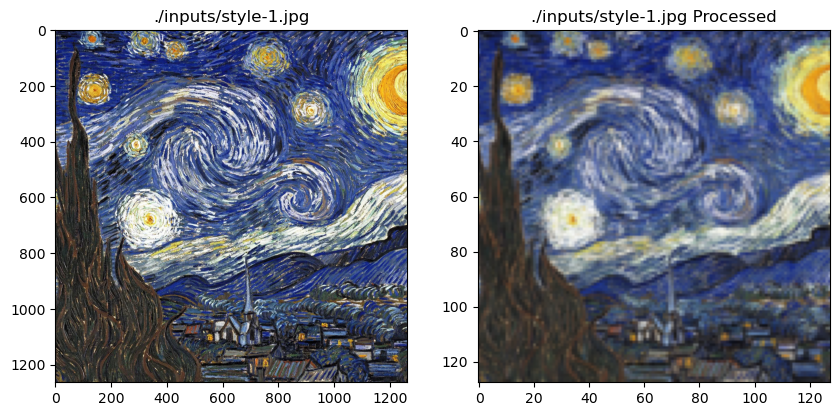

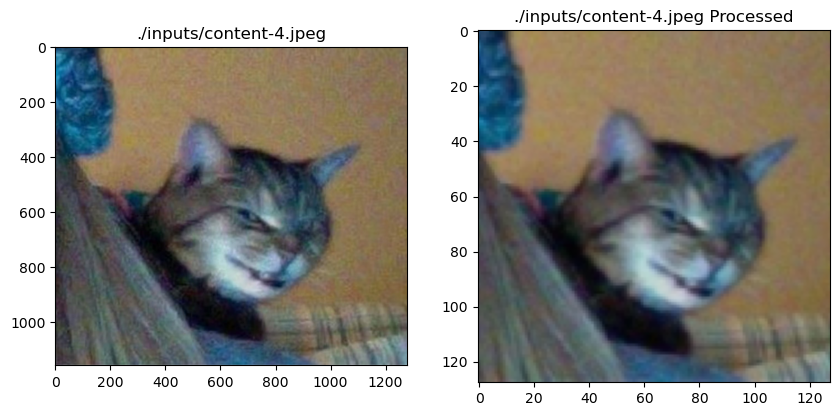

In [14]:
# Get Style and Content Tensors
style_image = image_to_tensor(f"{INPUT_PATH}/style-1.jpg", image_dimension).to(dvc).detach()
content_image = image_to_tensor(f"{INPUT_PATH}/content-4.jpeg", image_dimension).to(dvc).detach()
print(f"style_image.shape: {style_image.shape}")
print(f"content_image.shape: {content_image.shape}")

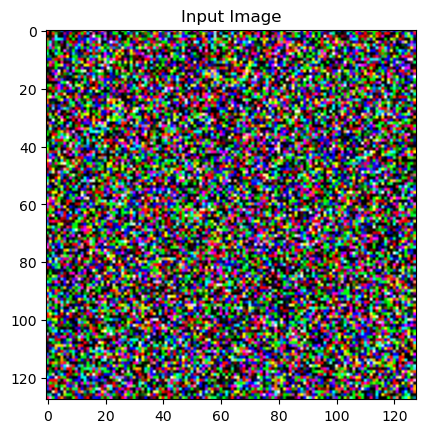

In [19]:
# Get Input Tensor
init_mode = "random"

if init_mode == "content":
    # initialize as the content image
    ip_image = content_image.clone().to(dvc)
else:
    ip_image = torch.randn(content_image.data.size(), device=dvc)

# Display input image
plt.figure()
plt.title("Input Image")
plt.imshow(ip_image.squeeze(0).cpu().detach().numpy().transpose(1,2,0).clip(0,1));

## Transfer the image

epoch number 10
style loss = 3.9085, content loss = 16.8081
epoch number 20
style loss = 4.2095, content loss = 14.0666
epoch number 30
style loss = 4.3352, content loss = 12.9946
epoch number 40
style loss = 4.4130, content loss = 12.3961
epoch number 50
style loss = 4.4407, content loss = 12.0610
epoch number 60
style loss = 4.4583, content loss = 11.8287
epoch number 70
style loss = 4.4688, content loss = 11.6480
epoch number 80
style loss = 4.4846, content loss = 11.4915
epoch number 90
style loss = 4.4849, content loss = 11.3913
epoch number 100
style loss = 4.4846, content loss = 11.3142


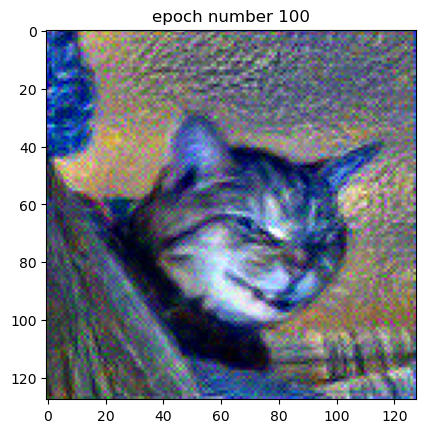

epoch number 110
style loss = 4.5011, content loss = 11.2277
epoch number 120
style loss = 4.5313, content loss = 11.1644
epoch number 130
style loss = 4.5805, content loss = 11.1982
epoch number 140
style loss = 4.5527, content loss = 11.0305
epoch number 150
style loss = 4.5094, content loss = 11.1568
epoch number 160
style loss = 4.5997, content loss = 11.2856
epoch number 170
style loss = 4.7696, content loss = 11.5471
epoch number 180
style loss = 4.6538, content loss = 11.0551
epoch number 190
style loss = 4.6089, content loss = 10.9661
epoch number 200
style loss = 4.6079, content loss = 11.1166


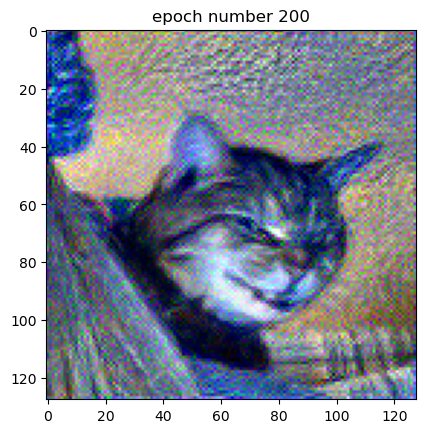

epoch number 210
style loss = 8.7032, content loss = 22.3737
epoch number 220
style loss = 4.9256, content loss = 12.4692
epoch number 230
style loss = 4.8241, content loss = 11.4280
epoch number 240
style loss = 4.7090, content loss = 11.3553
epoch number 250
style loss = 4.9116, content loss = 11.5909
epoch number 260
style loss = 5.4050, content loss = 13.7208
epoch number 270
style loss = 515.6326, content loss = 115.9958
epoch number 280
style loss = 6.1425, content loss = 18.3431
epoch number 290
style loss = 5.1955, content loss = 13.0386
epoch number 300
style loss = 4.9922, content loss = 12.0337


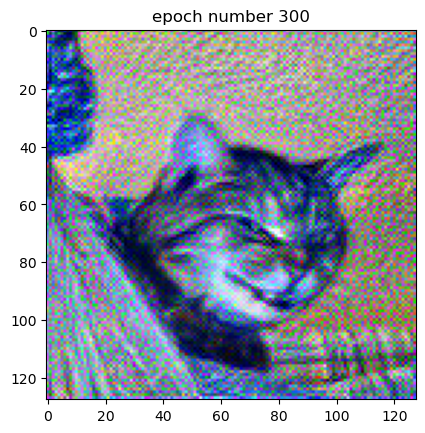

epoch number 310
style loss = 4.8611, content loss = 11.6470
epoch number 320
style loss = 4.8264, content loss = 11.7469
epoch number 330
style loss = 4.9270, content loss = 13.5710
epoch number 340
style loss = 9593.3516, content loss = 424.4475
epoch number 350
style loss = 53648.6211, content loss = 882.5646
epoch number 360
style loss = 33824.0312, content loss = 738.2867
epoch number 370
style loss = 70525.0859, content loss = 1009.2854
epoch number 380
style loss = 68563.0000, content loss = 1008.7825
epoch number 390
style loss = 46563.7852, content loss = 884.0015
epoch number 400
style loss = 6888.1748, content loss = 424.5703


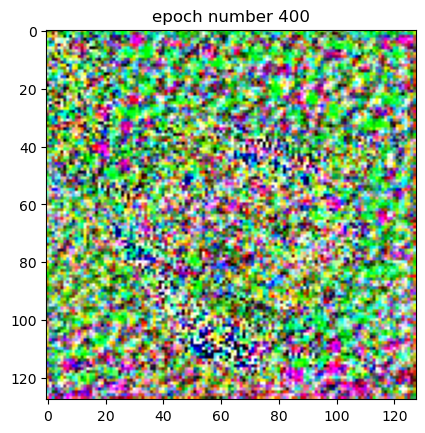

epoch number 410
style loss = 10.1085, content loss = 38.1070
epoch number 420
style loss = 5.6927, content loss = 23.1901
epoch number 430
style loss = 5.0482, content loss = 16.8166
epoch number 440
style loss = 4.6424, content loss = 14.5945
epoch number 450
style loss = 4.5848, content loss = 13.2908
epoch number 460
style loss = 4.5589, content loss = 12.5354
epoch number 470
style loss = 4.5934, content loss = 12.1483
epoch number 480
style loss = 4.6010, content loss = 12.8140
epoch number 490
style loss = 8.1128, content loss = 22.0365
epoch number 500
style loss = 4.8601, content loss = 12.6768


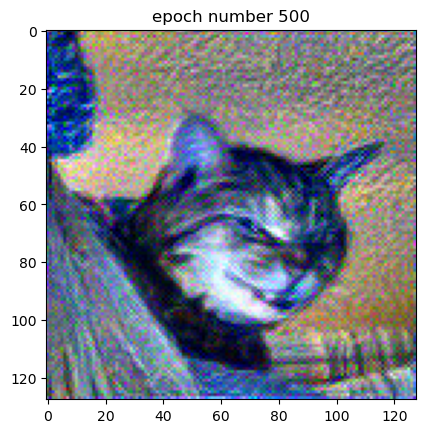

epoch number 510
style loss = 4.6148, content loss = 12.5797
epoch number 520
style loss = 5.1809, content loss = 13.8619
epoch number 530
style loss = 5.1219, content loss = 12.4570
epoch number 540
style loss = 4.6859, content loss = 12.0603
epoch number 550
style loss = 4.9891, content loss = 16.9886
epoch number 560
style loss = 29892.9336, content loss = 667.6372
epoch number 570
style loss = 47288.6875, content loss = 848.7031
epoch number 580
style loss = 43571.9141, content loss = 824.5200
epoch number 590
style loss = 45370.1172, content loss = 899.1730
epoch number 600
style loss = 7559.0210, content loss = 478.2061


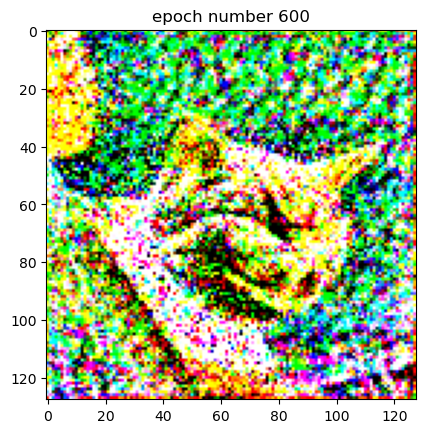

epoch number 610
style loss = 10.2176, content loss = 40.6703
epoch number 620
style loss = 5.2811, content loss = 19.8466
epoch number 630
style loss = 4.9734, content loss = 14.6474
epoch number 640
style loss = 4.6871, content loss = 13.2476
epoch number 650
style loss = 4.6502, content loss = 12.5670
epoch number 660
style loss = 4.6561, content loss = 12.7945
epoch number 670
style loss = 5.0906, content loss = 17.0278
epoch number 680
style loss = 9726.8359, content loss = 416.7770
epoch number 690
style loss = 33460.7969, content loss = 724.3041
epoch number 700
style loss = 11873.3916, content loss = 552.9908


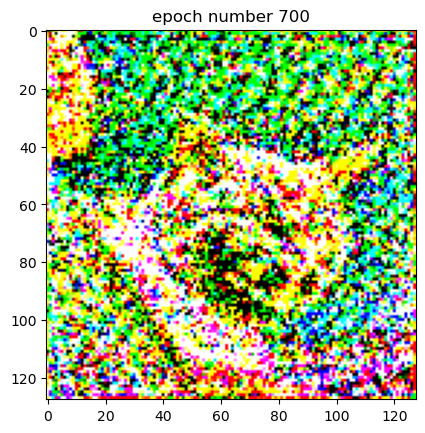

epoch number 710
style loss = 12012.3018, content loss = 498.5276
epoch number 720
style loss = 2587.8164, content loss = 244.6593
epoch number 730
style loss = 8.7628, content loss = 37.2746
epoch number 740
style loss = 4.6836, content loss = 16.8615
epoch number 750
style loss = 4.6597, content loss = 13.6773
epoch number 760
style loss = 4.6525, content loss = 12.5566
epoch number 770
style loss = 4.6460, content loss = 12.1733
epoch number 780
style loss = 8.4515, content loss = 21.9978
epoch number 790
style loss = 4.9890, content loss = 12.9237
epoch number 800
style loss = 4.6989, content loss = 12.3276


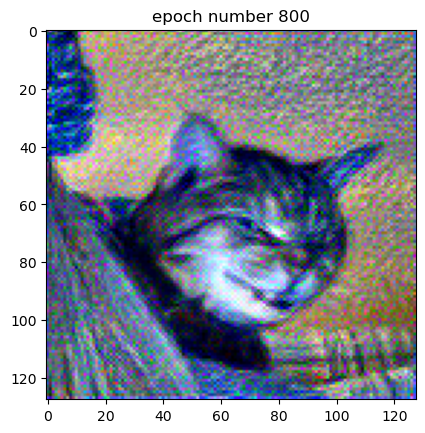

epoch number 810
style loss = 5.1419, content loss = 14.7897
epoch number 820
style loss = 290.5974, content loss = 104.1379
epoch number 830
style loss = 6.7924, content loss = 24.5151
epoch number 840
style loss = 5.1939, content loss = 13.7836
epoch number 850
style loss = 5.1172, content loss = 12.6060
epoch number 860
style loss = 5.8688, content loss = 19.0251
epoch number 870
style loss = 6.4281, content loss = 19.1631
epoch number 880
style loss = 7.9561, content loss = 22.5691
epoch number 890
style loss = 5.1337, content loss = 13.9388
epoch number 900
style loss = 4.8610, content loss = 15.0954


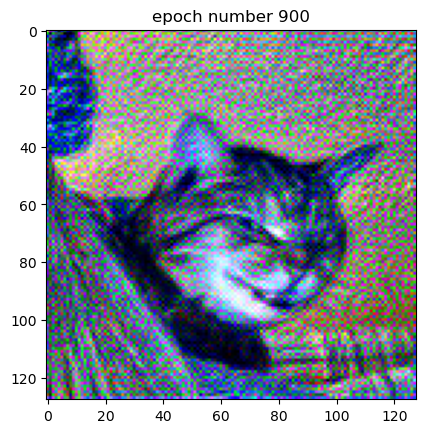

epoch number 910
style loss = 8074.5557, content loss = 397.4792
epoch number 920
style loss = 49853.1758, content loss = 861.6905
epoch number 930
style loss = 64336.5273, content loss = 990.0783
epoch number 940
style loss = 50642.0508, content loss = 895.7163
epoch number 950
style loss = 119978.3125, content loss = 1279.0188
epoch number 960
style loss = 105206.3828, content loss = 1232.6608
epoch number 970
style loss = 102757.1172, content loss = 1223.9653
epoch number 980
style loss = 6545.7700, content loss = 411.2782
epoch number 990
style loss = 11.5841, content loss = 43.4210
epoch number 1000
style loss = 5.9078, content loss = 26.8316


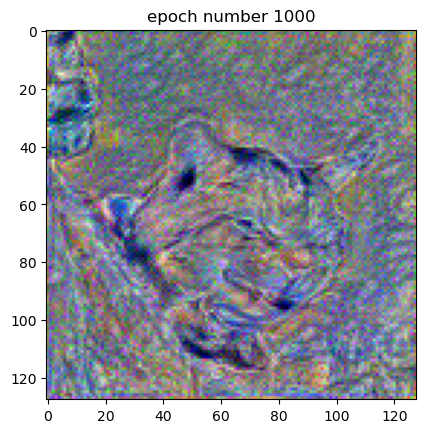

CPU times: user 17min 3s, sys: 38.7 s, total: 17min 41s
Wall time: 2min 55s


In [22]:
%%time

lr=1

wt_style=1e5
wt_content=8

num_epochs= 1000
loss_checkpoint_step = 10
image_checkpoint_step = 100

epoch_style_losses, epoch_content_losses = style_transfer(
    # Neural Network
    net,

    # Inputs
    ip_image,
    content_image,
    style_image,

    # Optimiser
    lr,

    # loss function
    wt_style,
    wt_content,

    # Transfering Process
    num_epochs,
    loss_checkpoint_step,
    image_checkpoint_step,

    OUTPUT_PATH
)

### Plot Loss Curve for further analysis

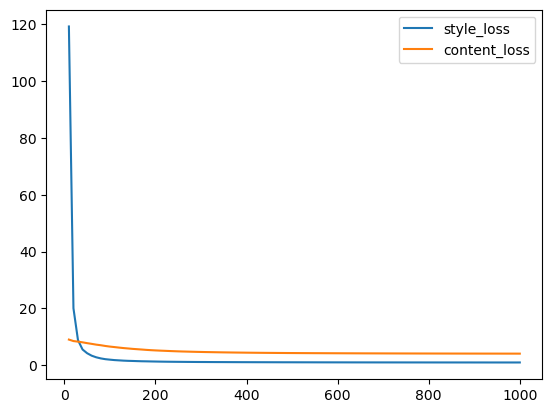

In [21]:
plt.plot(range(loss_checkpoint_step, num_epochs+1, loss_checkpoint_step), epoch_style_losses, label='style_loss');
plt.plot(range(loss_checkpoint_step, num_epochs+1, loss_checkpoint_step), epoch_content_losses, label='content_loss');
plt.legend();